# Autoencoders

Источник: keras blog

In [9]:
import keras
from keras import layers
from keras import backend as K
import matplotlib.pyplot as plt

###модель простейшего автоэнкодера
encoding_dim = 2
input_img = keras.Input(shape=(784,))
encoded1 = layers.Dense(64, activation='relu')(input_img)
encoded2 = layers.Dense(encoding_dim, activation='relu')(encoded1)

decoded2 = layers.Dense(64, activation='relu')(encoded2)
decoded = layers.Dense(784, activation='sigmoid')(decoded2) # poluchajem znachenija jarkosti dlja kazdogo pikselja znachenija
autoencoder = keras.Model(input_img, decoded)

In [11]:
# razbivajem model na 2 modulja, chtobq poluchit skrqtoe predstavlenije
encoder = keras.Model(input_img, encoded2) # objedenjajem
encoded_input = keras.Input(shape=(encoding_dim,))

decoder_layer_1 = autoencoder.layers[-1] # poluchajem vnutrennije predstavlenija
decoder_layer_2 = autoencoder.layers[-2]
decoder = keras.Model(encoded_input, decoder_layer_1(decoder_layer_2(encoded_input)))

In [12]:
autoencoder.compile(optimizer='adam', loss='mean_squared_error') # vs loss='binary_crossentropy'

In [13]:
from keras.datasets import mnist
import numpy as np
(x_train, _), (x_test, _) = mnist.load_data()

In [14]:
#normirujem izobrazenije k znachenijam ot 0 do 1
x_train = x_train.astype('float32') / 255.
x_test = x_test.astype('float32') / 255.
x_train = x_train.reshape((len(x_train), np.prod(x_train.shape[1:])))
x_test = x_test.reshape((len(x_test), np.prod(x_test.shape[1:])))
print(x_train.shape)
print(x_test.shape)

(60000, 784)
(10000, 784)


In [15]:
autoencoder.fit(x_train, x_train,
                epochs=50,
                batch_size=256,
                shuffle=True,
                validation_data=(x_test, x_test))

Epoch 1/50
235/235 [==============================] - 1s 4ms/step - loss: 0.0824 - val_loss: 0.0682
Epoch 2/50
235/235 [==============================] - 1s 3ms/step - loss: 0.0668 - val_loss: 0.0655
Epoch 3/50
235/235 [==============================] - 1s 3ms/step - loss: 0.0596 - val_loss: 0.0569
Epoch 4/50
235/235 [==============================] - 1s 4ms/step - loss: 0.0560 - val_loss: 0.0549
Epoch 5/50
235/235 [==============================] - 1s 4ms/step - loss: 0.0543 - val_loss: 0.0535
Epoch 6/50
235/235 [==============================] - 1s 4ms/step - loss: 0.0531 - val_loss: 0.0524
Epoch 7/50
235/235 [==============================] - 1s 4ms/step - loss: 0.0522 - val_loss: 0.0517
Epoch 8/50
235/235 [==============================] - 1s 4ms/step - loss: 0.0515 - val_loss: 0.0511
Epoch 9/50
235/235 [==============================] - 1s 4ms/step - loss: 0.0508 - val_loss: 0.0505
Epoch 10/50
235/235 [==============================] - 1s 4ms/step - loss: 0.0503 - val_loss: 0.0499

In [16]:
encoded_imgs = encoder.predict(x_test) # predstavlenije dlja testovqh izobrazenij
decoded_imgs = decoder.predict(encoded_imgs)

313/313 [==============================] - 0s 869us/step


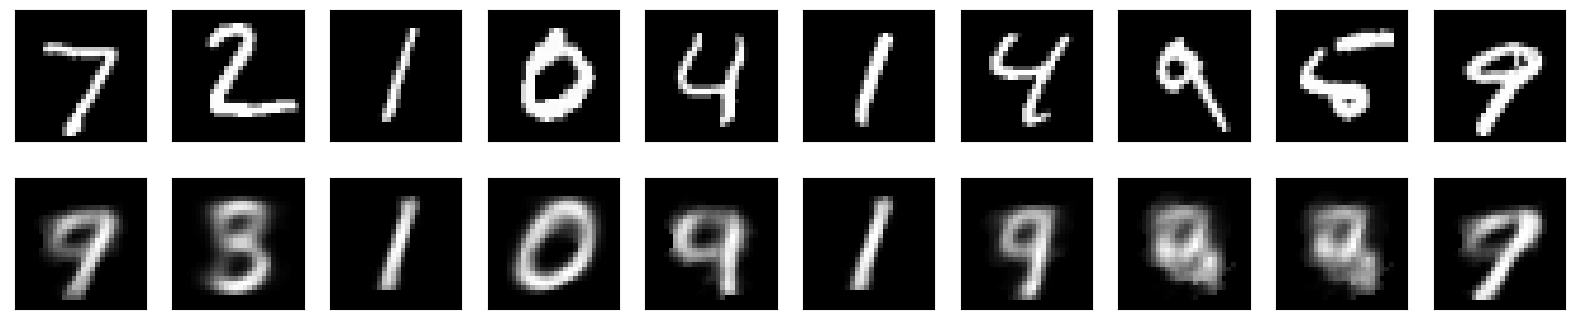

In [17]:
n = 10  # How many digits we will display
plt.figure(figsize=(20, 4))
for i in range(n):
    # Display original
    ax = plt.subplot(2, n, i + 1)
    plt.imshow(x_test[i].reshape(28, 28))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)

    # Display reconstruction
    ax = plt.subplot(2, n, i + 1 + n)
    plt.imshow(decoded_imgs[i].reshape(28, 28))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
plt.show()

1/1 [==============================] - 0s 15ms/step


1/1 [==============================] - 0s 12ms/step


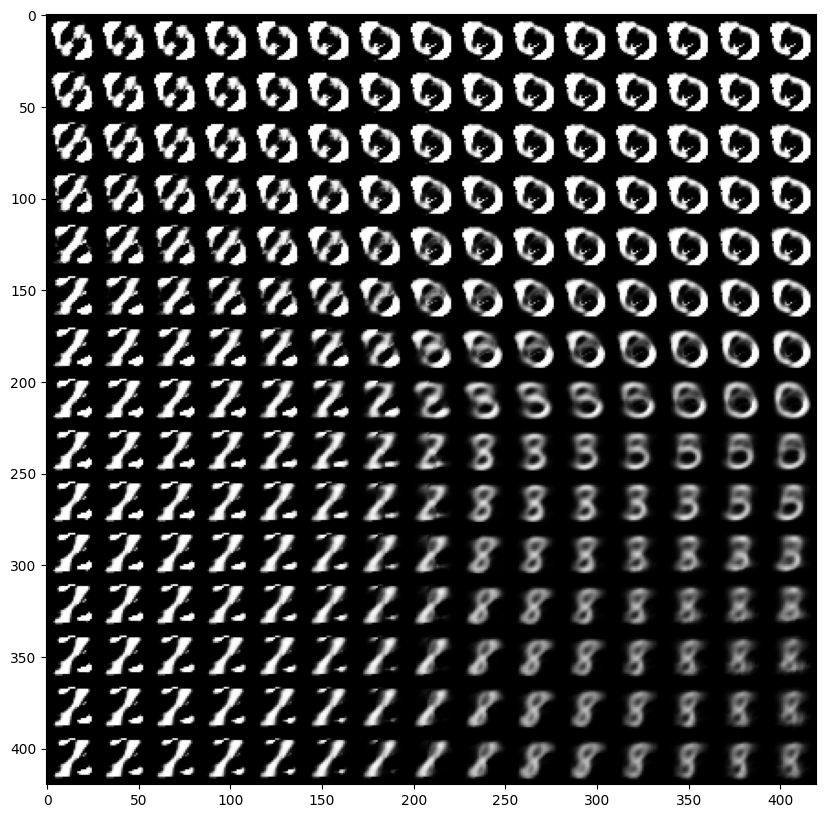

In [18]:
# Display a 2D manifold of the digits
# semplim izobrazenija iz 2mernogo prostranstva
n = 15  # figure with 15x15 digits
digit_size = 28
figure = np.zeros((digit_size * n, digit_size * n))
# We will sample n points within [-15, 15] standard deviations
grid_x = np.linspace(-10, 10, n)
grid_y = np.linspace(-10, 10, n)

for i, yi in enumerate(grid_x):
    for j, xi in enumerate(grid_y):
        z_sample = np.array([[xi, yi]])
        x_decoded = decoder.predict(z_sample)
        digit = x_decoded[0].reshape(digit_size, digit_size)
        figure[i * digit_size: (i + 1) * digit_size,
               j * digit_size: (j + 1) * digit_size] = digit

plt.figure(figsize=(10, 10))
plt.imshow(figure)
plt.show()

# Variational autoencoder

In [27]:
original_dim = 28 * 28
intermediate_dim = 64
latent_dim = 2

inputs = keras.Input(shape=(784,))
h = layers.Dense(intermediate_dim, activation='relu')(inputs)
z_mean = layers.Dense(2)(h) # 2 vektora, iz kotorqh budem semplirovat 
z_log_sigma = layers.Dense(2)(h)

In [ ]:
# N(mu, sigma) --> mu + eps*sigma, eps=N(0,1)
# reparametrezation trick - dlja podschitqvanije gradientov 

In [28]:

def sampling(args):
    z_mean, z_log_sigma = args
    epsilon = K.random_normal(shape=(K.shape(z_mean)[0], latent_dim),
                              mean=0., stddev=0.1)
    return z_mean + K.exp(z_log_sigma) * epsilon

z = layers.Lambda(sampling)([z_mean, z_log_sigma])

In [29]:
# Create encoder
vae_encoder = keras.Model(inputs, [z_mean, z_log_sigma, z], name='vae_encoder')

# Create decoder
latent_inputs = keras.Input(shape=(latent_dim,), name='z_sampling')
x = layers.Dense(intermediate_dim, activation='relu')(latent_inputs)
outputs = layers.Dense(original_dim, activation='sigmoid')(x)
vae_decoder = keras.Model(latent_inputs, outputs, name='decoder')

# instantiate VAE model
outputs = vae_decoder(vae_encoder(inputs)[2])
vae = keras.Model(inputs, outputs, name='vae_mlp')

In [30]:
reconstruction_loss = keras.losses.binary_crossentropy(inputs, outputs)
reconstruction_loss *= original_dim # forsirujem model, chtobq ona poluchala normalnoe raspredelenije v skrqtom predstavlenii
kl_loss = 1 + z_log_sigma - K.square(z_mean) - K.exp(z_log_sigma)
kl_loss = K.sum(kl_loss, axis=-1)
kl_loss *= -0.5
vae_loss = K.mean(reconstruction_loss + kl_loss) # kl devergency loss, 1 raspredenije maksimlano pohoze na drugoje raspredelenije
vae.add_loss(vae_loss)
vae.compile(optimizer='adam') #optimizer='rmsprop'

In [31]:
(x_train, y_train), (x_test, y_test) = mnist.load_data()

x_train = x_train.astype('float32') / 255.
x_test = x_test.astype('float32') / 255.
x_train = x_train.reshape((len(x_train), np.prod(x_train.shape[1:])))
x_test = x_test.reshape((len(x_test), np.prod(x_test.shape[1:])))

hist = vae.fit(x_train, x_train,
        epochs=50,
        batch_size=128,
        validation_data=(x_test, x_test),
        workers=-1,
        shuffle=True)

Epoch 1/50
469/469 [==============================] - 4s 7ms/step - loss: 221.5908 - val_loss: 182.0452
Epoch 2/50
469/469 [==============================] - 3s 7ms/step - loss: 176.0565 - val_loss: 170.1481
Epoch 3/50
469/469 [==============================] - 3s 7ms/step - loss: 168.6561 - val_loss: 166.3114
Epoch 4/50
469/469 [==============================] - 3s 7ms/step - loss: 165.7335 - val_loss: 164.4477
Epoch 5/50
469/469 [==============================] - 3s 7ms/step - loss: 163.9008 - val_loss: 162.8630
Epoch 6/50
469/469 [==============================] - 3s 7ms/step - loss: 162.3224 - val_loss: 161.5028
Epoch 7/50
469/469 [==============================] - 4s 8ms/step - loss: 160.8798 - val_loss: 160.1598
Epoch 8/50
469/469 [==============================] - 4s 9ms/step - loss: 159.7249 - val_loss: 159.3584
Epoch 9/50
469/469 [==============================] - 4s 9ms/step - loss: 158.7962 - val_loss: 158.4109
Epoch 10/50
469/469 [==============================] - 4s 8ms/st

313/313 [==============================] - 0s 580us/step


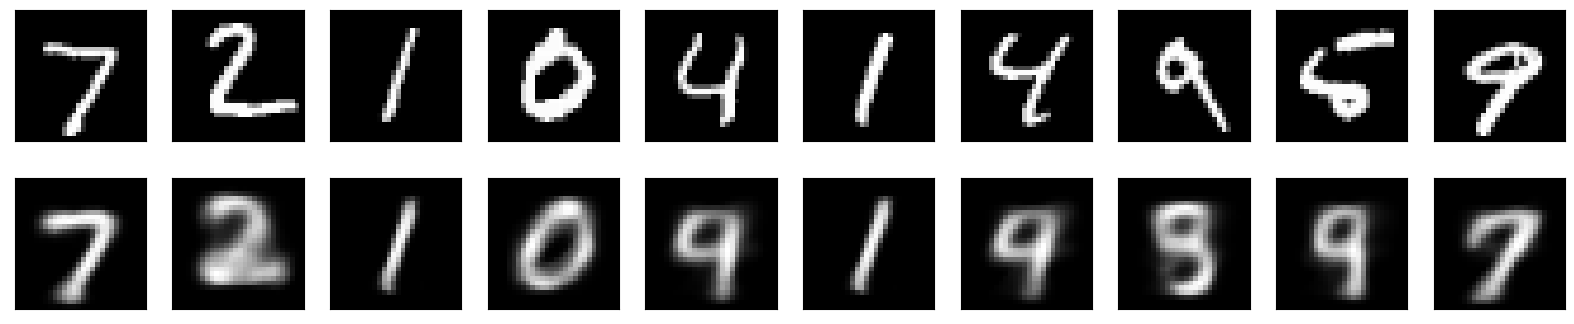

In [32]:
vae_encoded_imgs = vae_encoder.predict(x_test)
decoded_imgs = vae_decoder.predict(vae_encoded_imgs[2])

n = 10  # How many digits we will display
plt.figure(figsize=(20, 4))
for i in range(n):
    # Display original
    ax = plt.subplot(2, n, i + 1)
    plt.imshow(x_test[i].reshape(28, 28))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)

    # Display reconstruction
    ax = plt.subplot(2, n, i + 1 + n)
    plt.imshow(decoded_imgs[i].reshape(28, 28))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
plt.show()

1/1 [==============================] - 0s 15ms/step


1/1 [==============================] - 0s 16ms/step


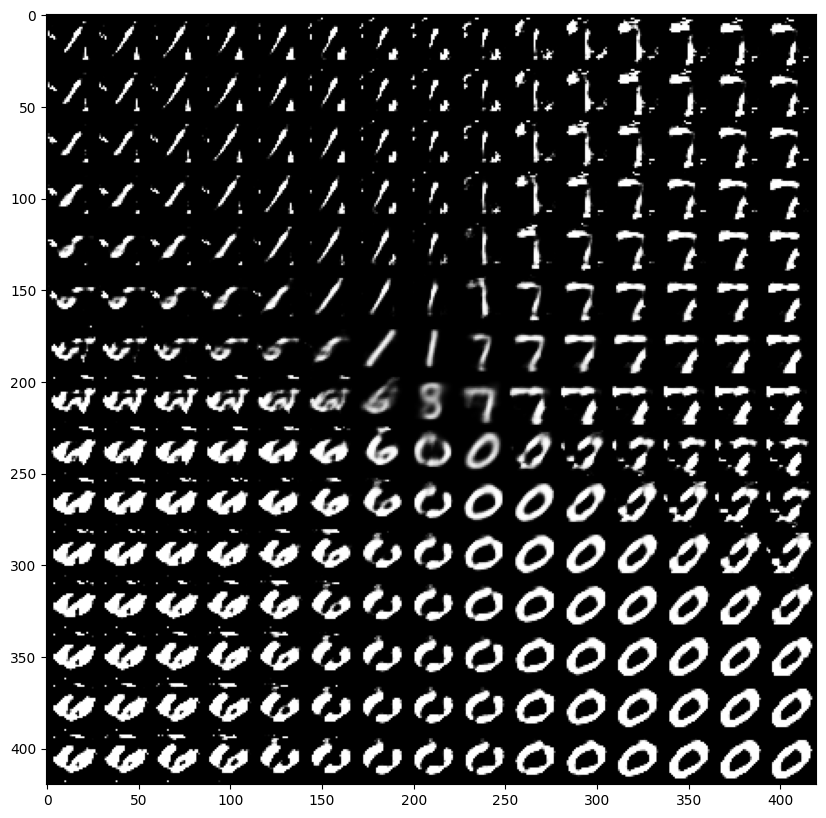

In [34]:
n = 15  # figure with 15x15 digits
digit_size = 28
figure = np.zeros((digit_size * n, digit_size * n))
# We will sample n points within [-15, 15] standard deviations
grid_x = np.linspace(-15, 15, n)
grid_y = np.linspace(-15, 15, n)

for i, yi in enumerate(grid_x):
    for j, xi in enumerate(grid_y):
        z_sample = np.array([[xi, yi]])
        x_decoded = vae_decoder.predict(z_sample)
        digit = x_decoded[0].reshape(digit_size, digit_size)
        figure[i * digit_size: (i + 1) * digit_size,
               j * digit_size: (j + 1) * digit_size] = digit

plt.figure(figsize=(10, 10))
plt.imshow(figure)
plt.show()